<p>Набор данных демонстрирует потребление энергии в городе Тетуан в Марокко. Распределительная сеть обслуживается тремя зональными станциями</p>
<p>Данные состоят из 52 416 наблюдений энергопотребления в 10-минутном окне. Каждое наблюдение описывается 9 столбцами признаков:
<p>Date Time: Временное окно продолжительностью десять минут.</p>
<p>Temperature: температура погоды.</p>
<p>Humidity: Влажность погоды.</p>
<p>Wind Speed: Скорость ветра.</p>
<p>General Diffuse Flows: «Диффузный поток» — это общий термин для описания низкотемпературных (от < 0,2° до ~ 100°C) флюидов, которые медленно разряжаются через сульфидные насыпи, трещиноватые потоки лавы и скопления бактериальных матов и макрофауны.</p>
<p>Diffuse Flows</p>
<p>Zone 1 Power Consumption</p>
<p>Zone 2 Power Consumption</p>
<p>Zone 3 Power Consumption</p>

<p>Задача исследования - спрогнозировать потребление энергии на каждой станции на горизонте 1 месяца. Будем считать, что информация о прогнозе погодных условий доступна,а целевые переменные - потребление энергии на каждой из станций.</p>

<h2>Dataloader</h2>

In [2]:
import kagglehub
from torch.utils.data import Dataset, DataLoader

In [3]:
class EnergyConsumptionTimeseries(Dataset):
    def __init__(self, csv_file):
        self.df_raw = self.df_preprocessed = pd.read_csv(csv_file)
        self._preprocess()

        self.targets_labels = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']

    def resample_timeseries(self, step='h'):
        self.df_preprocessed = self.df_preprocessed.resample(step).mean()

    def _preprocess(self):
        self.df_preprocessed['Datetime'] = pd.to_datetime(self.df_raw.Datetime)
        self.df_preprocessed.set_index('Datetime', inplace=True)

    def get_targets(self):
        return self.df_preprocessed[self.targets_labels]

    def get_features(self):
        return self.df_preprocessed.drop(columns=self.targets_labels)

    def get_statistics(self):
        # Статистика по датасету
        num_records = self.df_preprocessed.shape[0]
        num_fields = self.df_preprocessed.shape[1]
        record_size_bits = self.df_preprocessed.memory_usage(deep=True).sum() * 8 / num_records
        num_features = self.df_preprocessed.shape[1] - 1
        missing_values = self.df_preprocessed.isna().sum()
        data_types = self.df_preprocessed.dtypes
        print(f"Количество записей: {num_records}")
        print(f"Количество полей: {num_fields}")
        print(f"Объем одной записи в битах: {record_size_bits:.2f} бит")
        print(f"Количество фичей: {num_features}")
        print("Количество пропусков:\n", missing_values)
        print("Типы данных:\n", data_types)
        # Проверка целостности ряда, шага и хронологического порядка
        self.df_preprocessed.sort_index(ascending=True, inplace=True)
        chronological_order = self.df_preprocessed.index.is_monotonic_increasing
        time_diffs = self.df_preprocessed.index.diff()
        equidistant_timestamps = time_diffs.nunique() == 1
        print('Ряд в хронологическом порядке: ', chronological_order)
        print('Ряд целостный: ', equidistant_timestamps)
        print('Временные шаги:', time_diffs)

    def get_raw_data(self):
        return self.df_raw

    def get_preprocessed_data(self):
        return self.df_preprocessed

    def apply_transform_func(self, func):
        self.df_preprocessed = func(self.df_preprocessed)

    def __len__(self):
        return len(self.df_preprocessed)


<h2>Предобработка</h2>

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = EnergyConsumptionTimeseries('/content/drive/MyDrive/time_series/power-consumption/powerconsumption.csv')

In [6]:
df.get_statistics()

Количество записей: 52416
Количество полей: 8
Объем одной записи в битах: 576.00 бит
Количество фичей: 7
Количество пропусков:
 Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64
Типы данных:
 Temperature               float64
Humidity                  float64
WindSpeed                 float64
GeneralDiffuseFlows       float64
DiffuseFlows              float64
PowerConsumption_Zone1    float64
PowerConsumption_Zone2    float64
PowerConsumption_Zone3    float64
dtype: object
Ряд в хронологическом порядке:  True
Ряд целостный:  True
Временные шаги: TimedeltaIndex([              NaT, '0 days 00:10:00', '0 days 00:10:00',
                '0 days 00:10:00', '0 days 00:10:00', '0 days 00:10:00',
                '0 days 00:10:00', '0 days 00:10:00', '0 days 00:10:00',
                '0 days 00:10:00',
       

<h2>EDA</h2>

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
df.resample_timeseries('h')

In [9]:
df_preprocessed = df.get_preprocessed_data()
targets = df.get_targets()
features = df.get_features()

<p>График временного ряда</p>

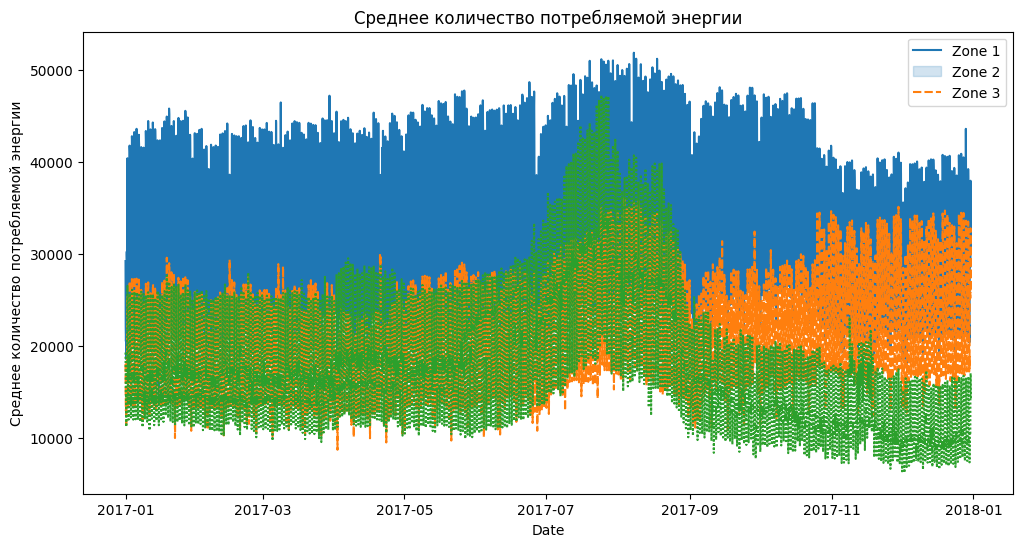

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=targets)
plt.xlabel('Date')
plt.ylabel('Среднее количество потребляемой энергии')
plt.title('Среднее количество потребляемой энергии')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

<p>Корреляционная матрица</p>

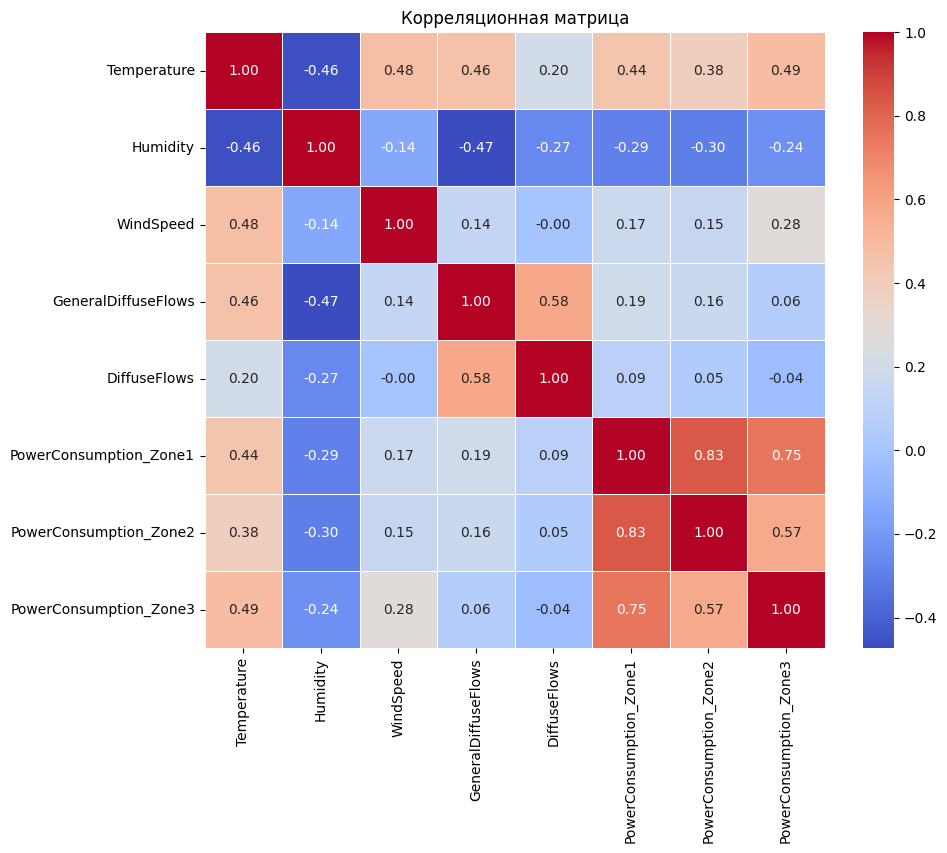

In [ ]:
correlation_matrix = df_preprocessed.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

<p>Автокорреляция и частичная автокорреляция</p>

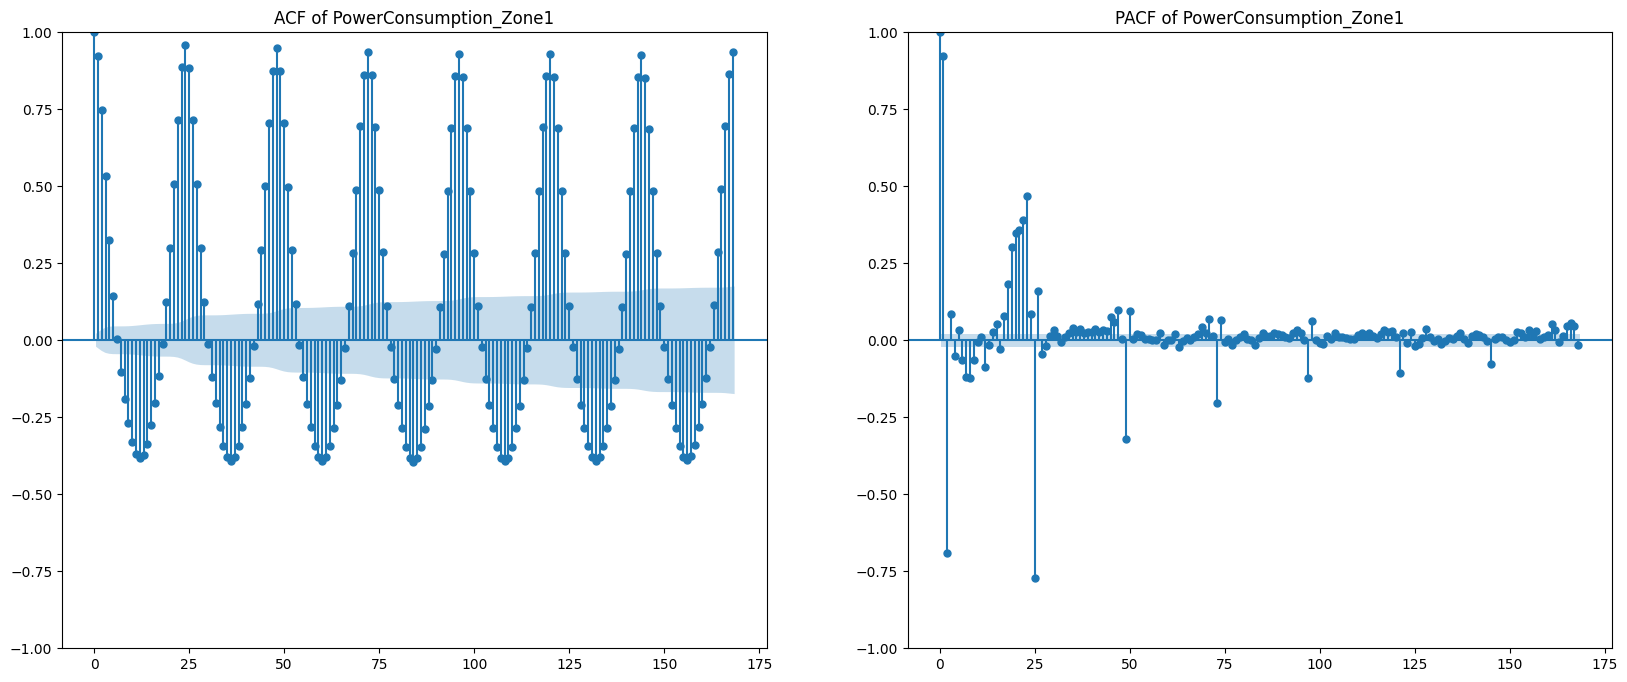

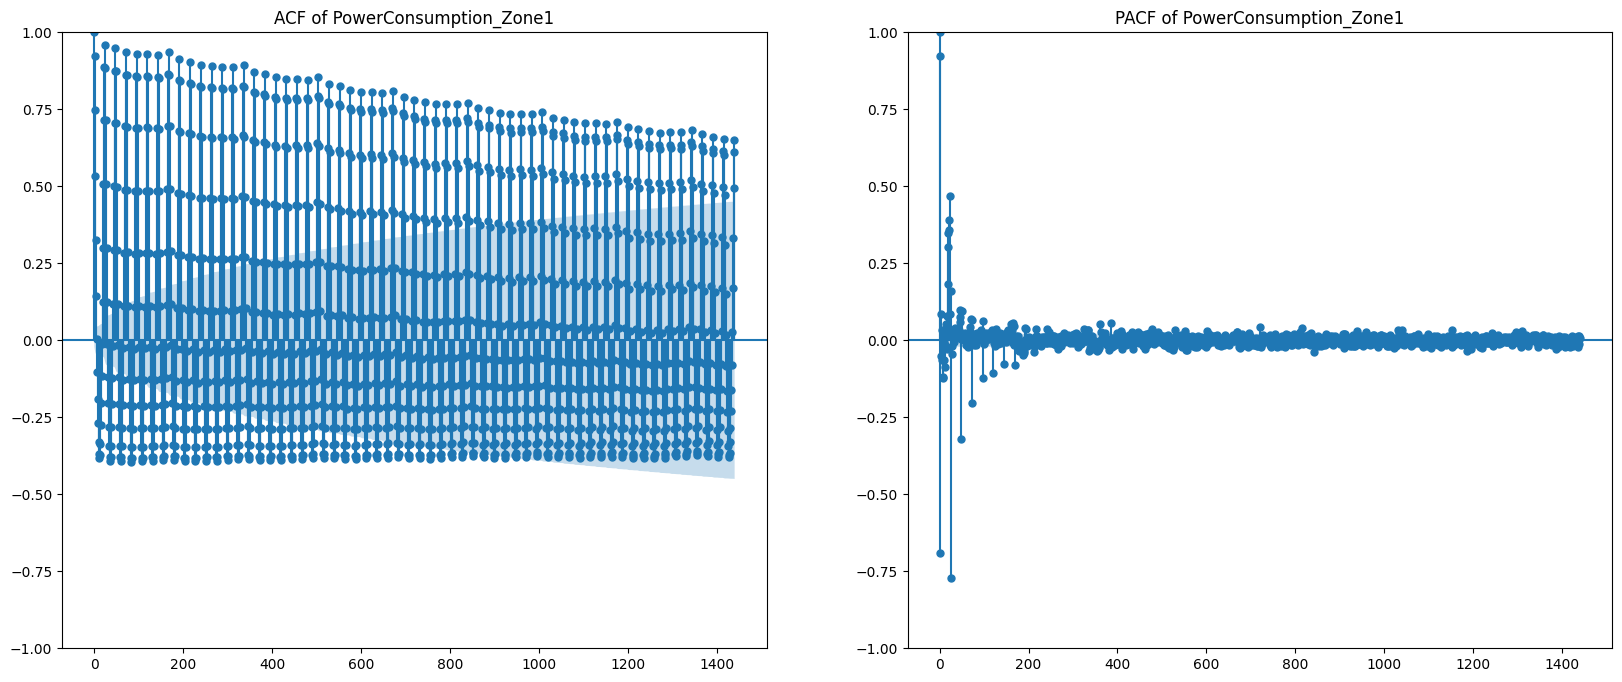

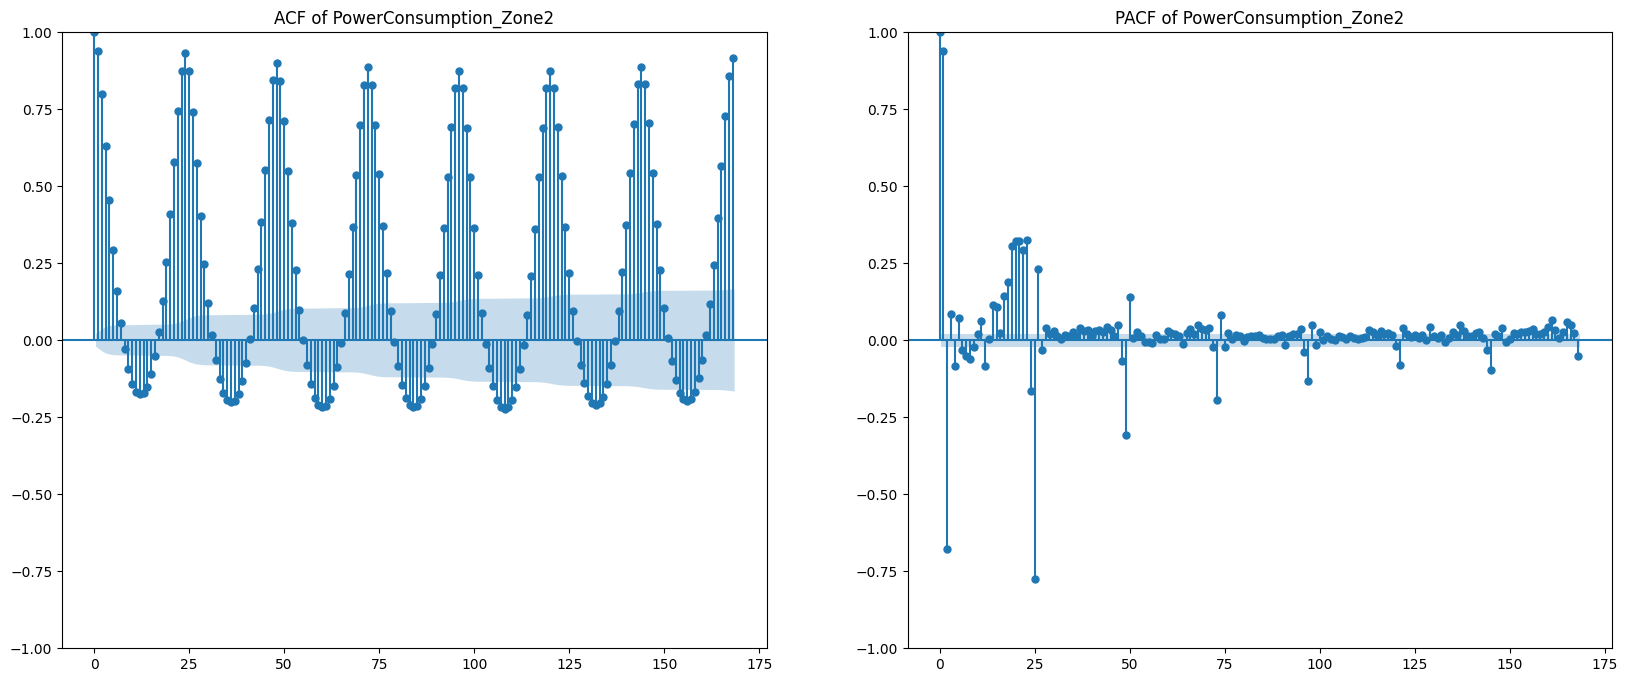

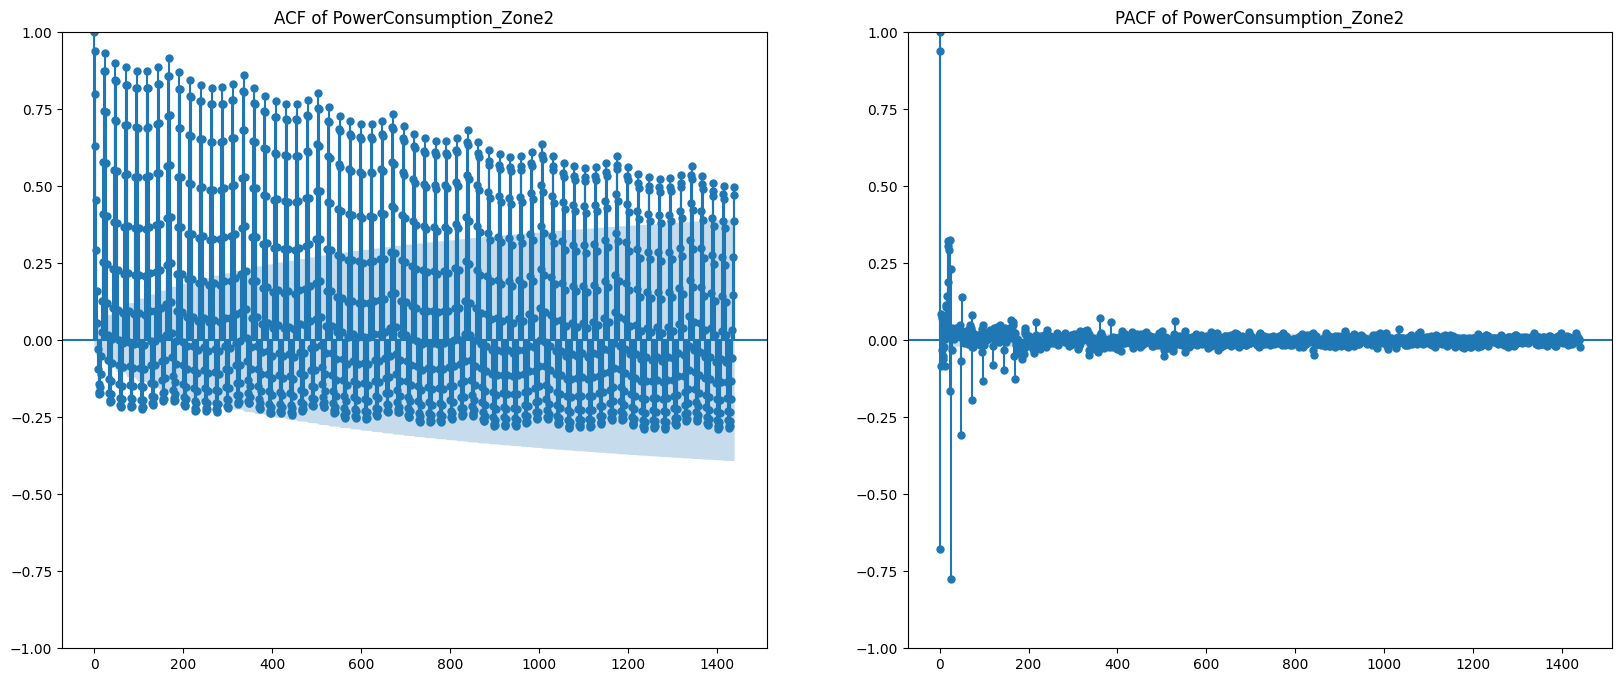

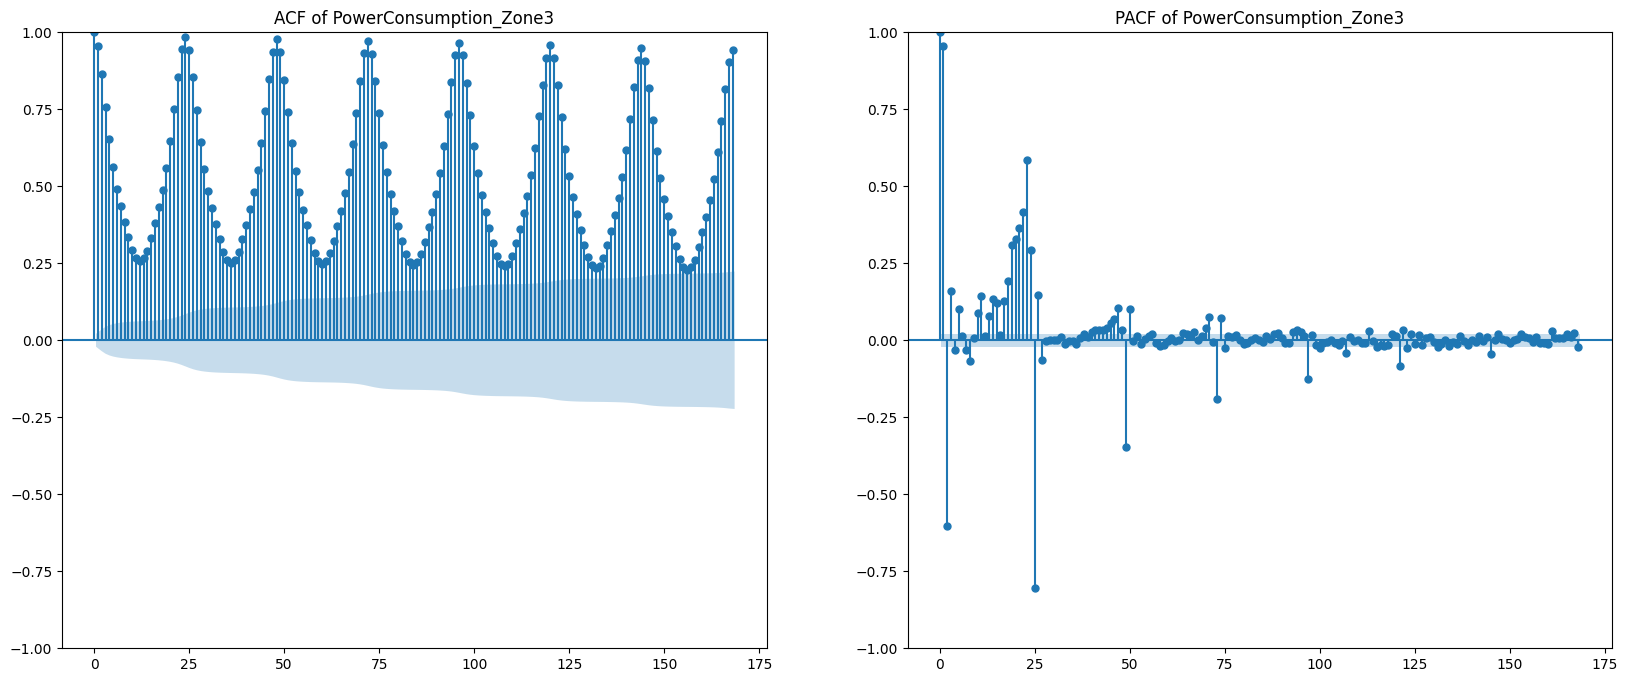

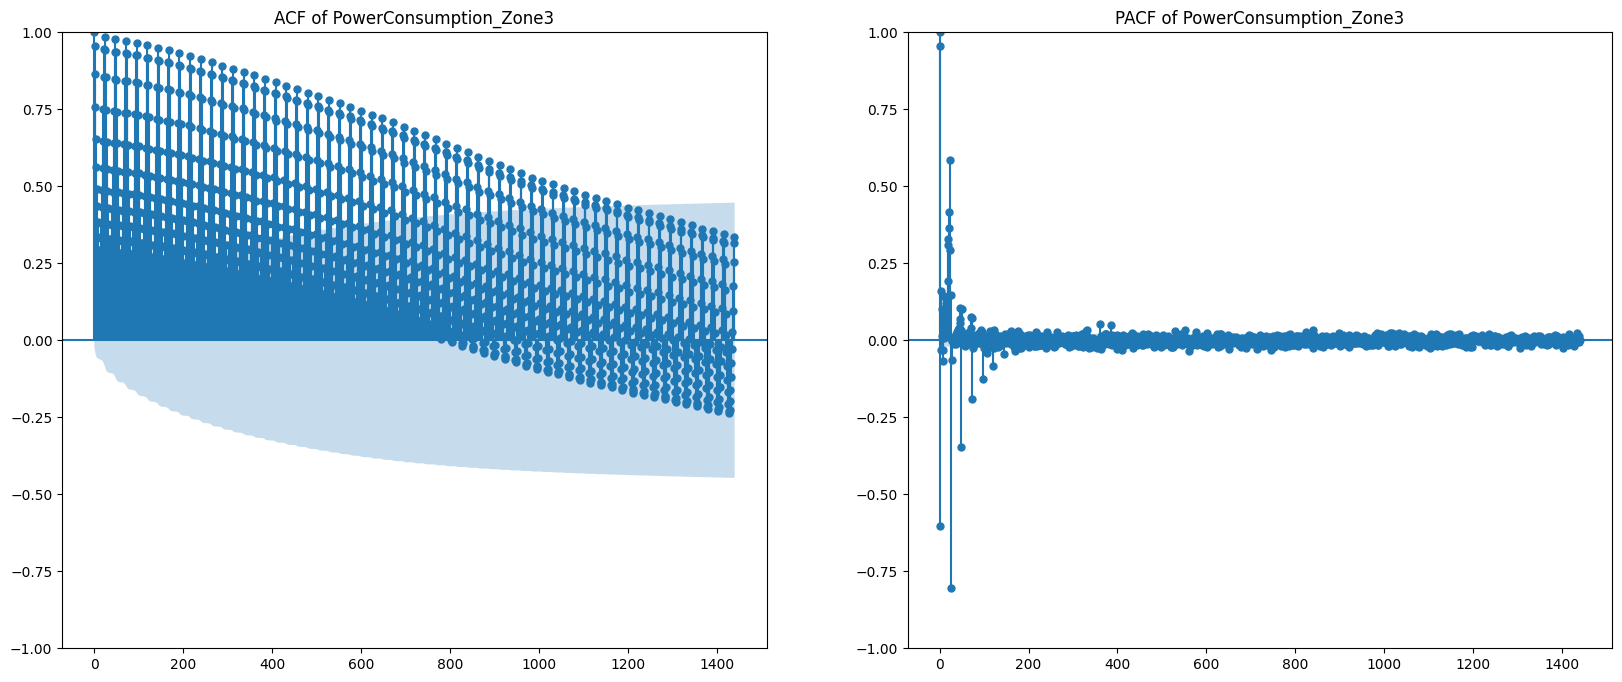

In [ ]:
def plot_acf_pacf(series, num_lags):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    # ACF
    plot_acf(series, ax=ax[0], lags=num_lags)
    ax[0].set_title(f'ACF of {column}')

    # PACF
    plot_pacf(series, ax=ax[1], lags=num_lags)
    ax[1].set_title(f'PACF of {column}')

    plt.show()

# Вызов функции для построения графиков
for column in targets.columns:
    plot_acf_pacf(targets[column], 168)
    plot_acf_pacf(targets[column], 1440)

Декомпозиция

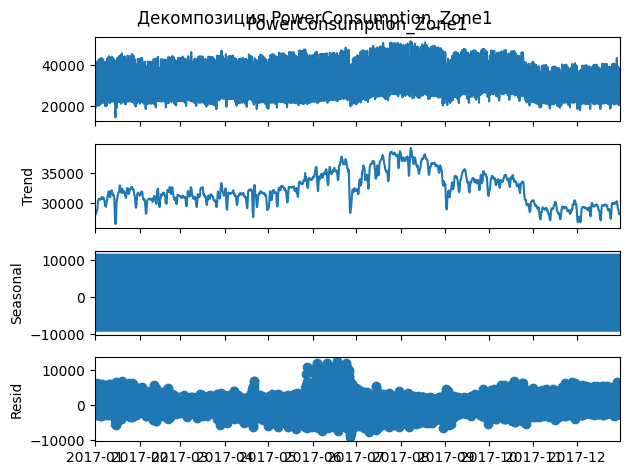

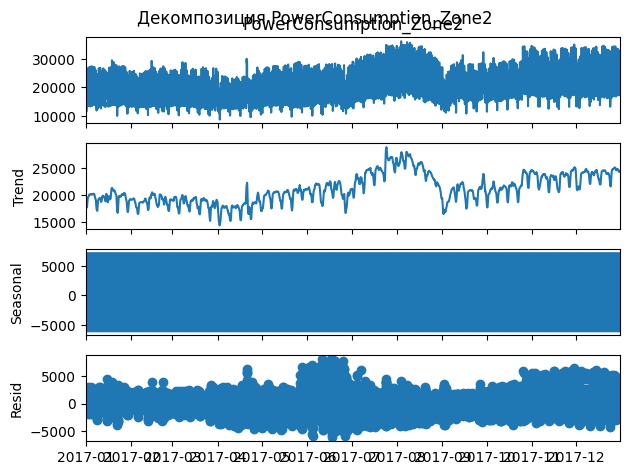

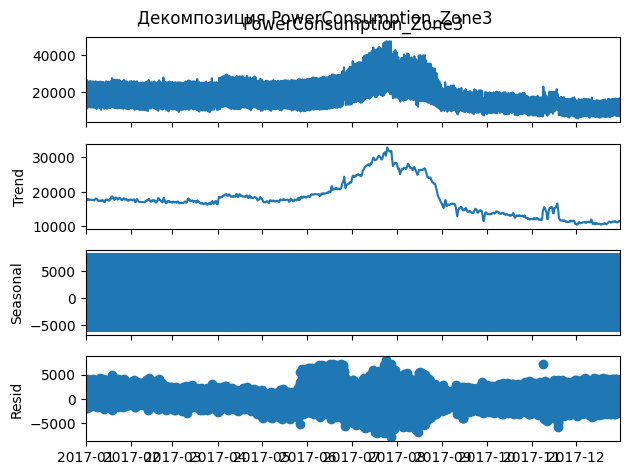

In [ ]:
# Декомпозиция временных рядов
def decompose_and_plot(series, title):
    result = seasonal_decompose(series, model='additive')  # Период сезонности
    result.plot()
    plt.suptitle(title)
    plt.show()

# Декомпозиция для каждого временного ряда
for i, column in enumerate(targets.columns):
    decompose_and_plot(targets[column], f'Декомпозиция {column}')

<p>Проверка на стационарность</p>

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def check_stationarity(series, column):
    # Выполняем тест Дики-Фуллера
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    # Проверяем p-value
    if result[1] <= 0.05:
        print(f'Ряд {column} стационарен (отвергаем нулевую гипотезу)')
    else:
        print(f'Ряд {column} нестационарен (не отвергаем нулевую гипотезу)')

# Проверяем стационарность временного ряда
for i, column in enumerate(targets.columns):
    check_stationarity(targets[column], column)

ADF Statistic: -4.445856092337927
p-value: 0.00024601641924986193
Critical Values:
   1%: -3.4311020385052733
   5%: -2.8618723508056814
   10%: -2.566946905374546
Ряд PowerConsumption_Zone1 стационарен (отвергаем нулевую гипотезу)
ADF Statistic: -4.685281696929026
p-value: 8.967662424155362e-05
Critical Values:
   1%: -3.4311020385052733
   5%: -2.8618723508056814
   10%: -2.566946905374546
Ряд PowerConsumption_Zone2 стационарен (отвергаем нулевую гипотезу)
ADF Statistic: -1.2611801593786371
p-value: 0.6467401262078909
Critical Values:
   1%: -3.4311010883544237
   5%: -2.8618719309555227
   10%: -2.5669466818853945
Ряд PowerConsumption_Zone3 нестационарен (не отвергаем нулевую гипотезу)


<p>Тест на нормальность распределения (тест Шапиро-Уилка)</p>

In [ ]:
from scipy import stats

In [ ]:
stat, p_value = stats.shapiro(targets)

# Вывод результатов
print('Statistics:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('Данные распределены нормально (не отвергаем H0)')
else:
    print('Данные не распределены нормально (отвергаем H0)')

Statistics: 0.9694059187276475
p-value: 9.178248988928655e-58
Данные не распределены нормально (отвергаем H0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26208.
  res = hypotest_fun_out(*samples, **kwds)


Тест на белый шум

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [13]:
# Тест на белый шум
for target in targets.columns.to_list():
    result = acorr_ljungbox(targets[target], lags=[144])
    print('Ljung-Box test statistic and p-value:\n', result)

Ljung-Box test statistic and p-value:
            lb_stat  lb_pvalue
144  265668.837769        0.0
Ljung-Box test statistic and p-value:
            lb_stat  lb_pvalue
144  239472.557326        0.0
Ljung-Box test statistic and p-value:
            lb_stat  lb_pvalue
144  434644.451531        0.0


<p>Выбросы</p>

In [14]:
from scipy import stats

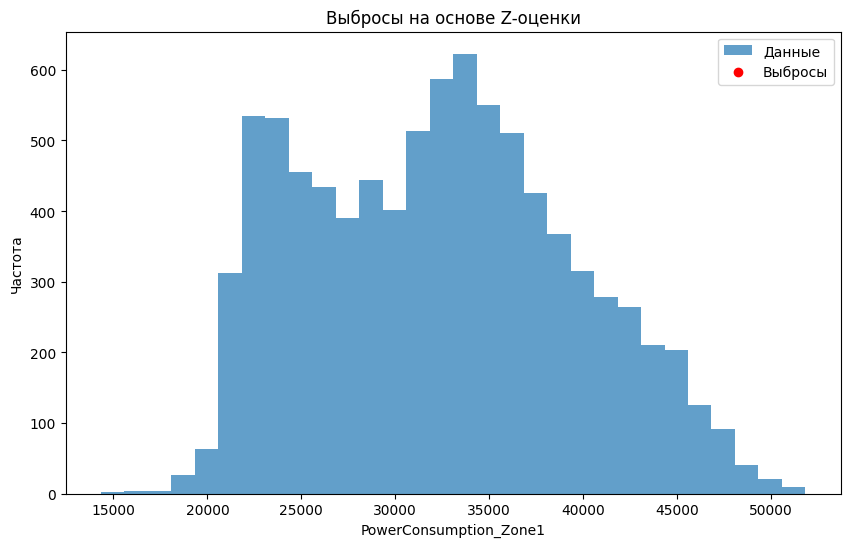

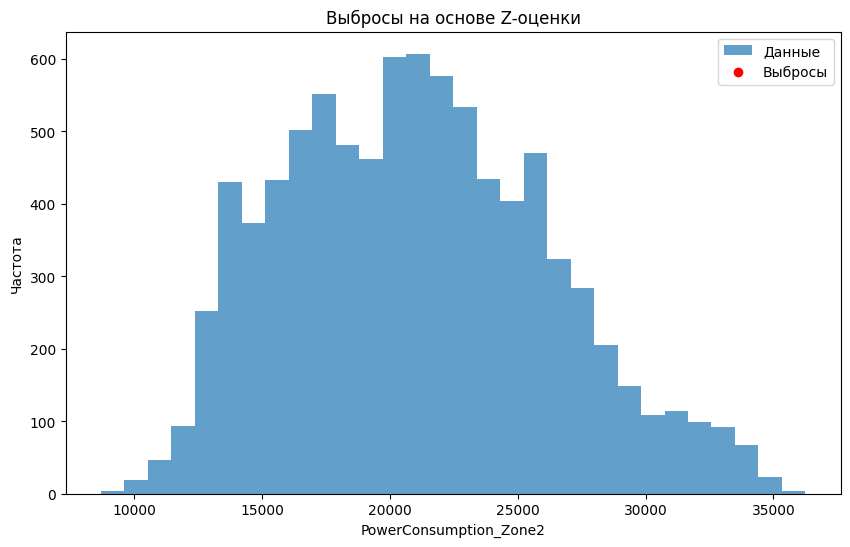

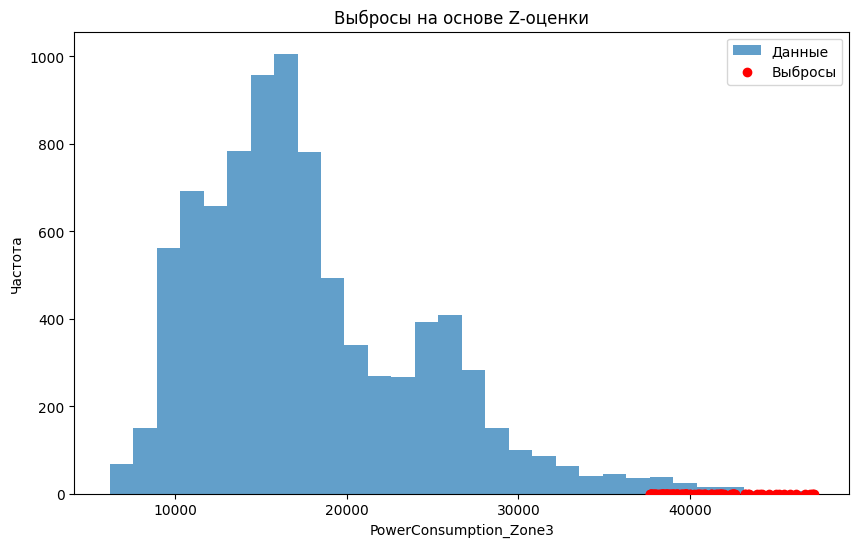

In [15]:
for column in targets.columns.to_list():
    z_scores = stats.zscore(targets[column])

    threshold = 3
    outliers = targets[column][abs(z_scores) > threshold]

    plt.figure(figsize=(10, 6))
    plt.hist(targets[column], bins=30, alpha=0.7, label='Данные')
    plt.scatter(outliers, [0] * len(outliers), color='red', label='Выбросы', zorder=5)
    plt.title('Выбросы на основе Z-оценки')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.legend()
    plt.show()

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
for target in targets.columns.to_list():
    ts = targets[target].copy()
    model = ExponentialSmoothing(ts)
    fit = model.fit()

    ts_smoothed = fit.fittedvalues

    targets[target] = ts_smoothed

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-186-a74be68cf40a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets[target] = ts_smoothed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-186-a74be68cf40a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<h2>Инструменты</h2>

In [ ]:
def get_train_test(targets, features, train_index, test_index):
    train_targets, test_targets = targets.iloc[train_index], targets.iloc[test_index]
    train_features, test_features = features.iloc[train_index], features.iloc[test_index]
    return train_features, train_targets, test_features, test_targets

<h2>SARIMAX</h2>

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
#import optuna

In [ ]:
df_preprocessed = df.get_preprocessed_data()
targets = df.get_targets()[1440:]
features = df.get_features()[1440:]

In [ ]:
# Включим функции ряда Фурье как дополнительные регрессоры
# Параметры
#period = 336  # Период сезонности (168 часов в неделе)
#features['fourirer_seasonal'] = 0
# Создание компонент Фурье
#sin_fourier = np.sin(2 * np.pi * 1 * np.arange(len(features)) / period)
#cos_fourier = np.cos(2 * np.pi * 1 * np.arange(len(features)) / period)
#features['fourirer_seasonal'] += sin_fourier+cos_fourier
#features

In [ ]:
best_params = {
    's': 24,
    'p': 1,
    'q': 1,
    'd': 1,
    'P': 1,
    'Q': 1,
    'D': 1}

In [ ]:
# Предскажем последнюю неделю на модели с лучшими параметрами
pred_len = 168
train_size = len(targets) - pred_len
train_data = targets.iloc[:train_size]
test_data = targets.iloc[train_size:]

X_train, y_train = features.iloc[:train_size], targets[:train_size]
X_test, y_test = features.iloc[train_size:], targets[train_size:]

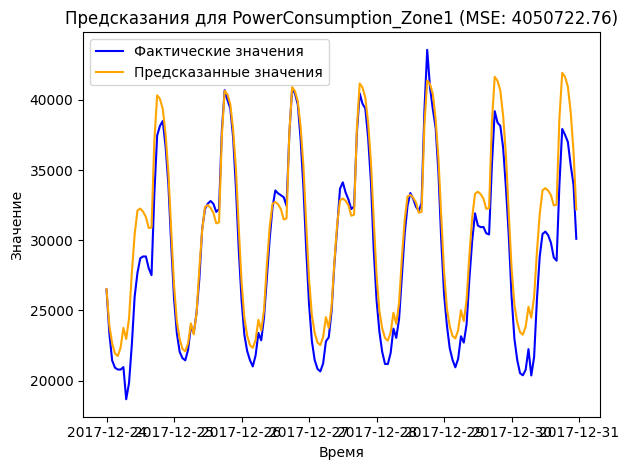

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


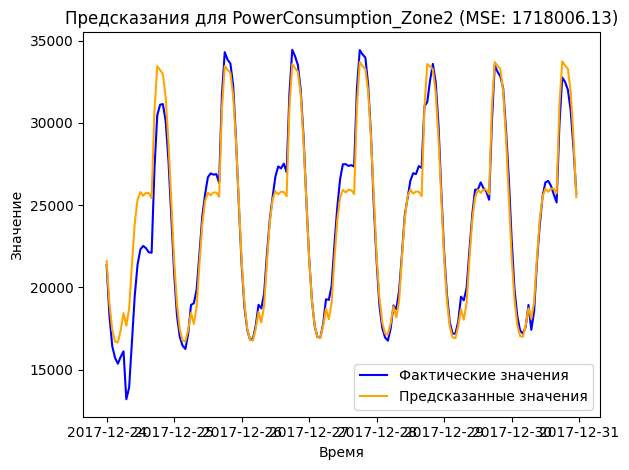

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


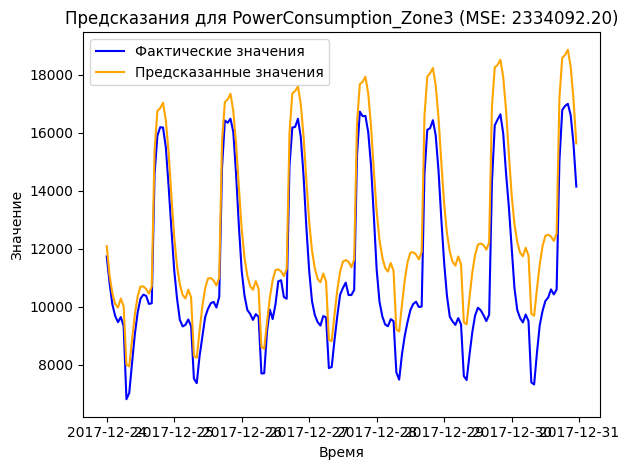

In [ ]:
for target in y_train.columns.to_list():
    model = SARIMAX(endog=y_train[target], exog=X_train, order=(best_params['p'], best_params['d'], best_params['q']), seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']))
    results = model.fit(disp=True)
    predictions = results.forecast(steps=len(y_test[target]), exog=X_test)
    # Вычисление ошибки
    mse_value = mean_squared_error(y_test[target], predictions)

    # Построение графика фита
    plt.plot(y_test.index, y_test[target], label='Фактические значения', color='blue')
    plt.plot(y_test.index, predictions, label='Предсказанные значения', color='orange')
    plt.title(f'Предсказания для {target} (MSE: {mse_value:.2f})')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()

    # Вывод графиков
    plt.tight_layout()
    plt.show()


<h2>Прогнозирование с XGDBoost</h2

<p>Для прогнозирования ряда использован градиентный бустинг</p>
<p>Обоснование выбора метрики:</p>
Выбор метрики: Метрика должна соответствовать задаче, которую решает модель. Для задач регрессии популярными метриками являются:
Среднеквадратичная ошибка (MSE): Хорошо подходит для оценки ошибок в предсказаниях, особенно если важно учитывать большие ошибки.
Средняя абсолютная ошибка (MAE): Менее чувствительна к выбросам, что делает её подходящей для задач, где выбросы могут искажать результаты.
R² (коэффициент детерминации): Позволяет оценить, насколько хорошо модель объясняет вариацию в данных.
Сравнение моделей: Метрика должна быть одной и той же для всех моделей, которые вы сравниваете. Это обеспечивает справедливое сравнение производительности различных алгоритмов.
Оценка на валидационной выборке: Использование валидационной выборки для оценки метрики позволяет избежать переобучения и получить более реалистичную оценку производительности модели на новых данных.
<p>Выбор методики испытаний и обоснование:</p>
<p>Кросс-валидация: позволяет более надежно оценить производительность модели. Это помогает избежать случайных результатов, связанных с конкретным разделением данных на обучающую и тестовую выборки.</p>
<p>Оптимизация гиперпараметров: Проведение испытаний с различными гиперпараметрами (например, количеством деревьев, глубиной деревьев, скоростью обучения) позволяет оценить, как настройки влияют на производительность модели. Оптимизация параметров производится с использованием Optuna</p>

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import functools
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance, plot_tree
import optuna

In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))

    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)


    return df.astype(float)

In [ ]:
df.apply_transform_func(create_features)

In [ ]:
df_preprocessed = df.get_preprocessed_data()
targets = df.get_targets()
features = df.get_features()

In [ ]:
def evaluate_model_with_time_series_split(targets, features, model_params, show_plots=False):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []

    fold = 0
    for train_index, test_index in tscv.split(targets):
        X_train, y_train, X_test, y_test  = get_train_test(targets, features, train_index, test_index)

        model = xgb.XGBRegressor(**model_params)
        model.fit(X_train, y_train, verbose=False)
        predictions = model.predict(X_test)

        # Вычисление ошибки
        mse_value = mean_squared_error(y_test, predictions)
        mse_scores.append(mse_value)

        if show_plots:
            # Построение графика фита
            plt.plot(y_test.index, y_test, label='Фактические значения', color='blue')
            plt.plot(y_test.index, predictions, label='Предсказанные значения', color='orange')
            plt.title(f'Фит для разбиения {fold + 1} (MSE: {mse_value:.2f})')
            plt.xlabel('Время')
            plt.ylabel('Значение')
            plt.legend()

            # Вывод графиков
            plt.tight_layout()
            plt.show()

            fold += 1

    return np.mean(mse_scores)

In [ ]:
n_splits = 12

In [ ]:
def opt(trial):
    params = {
      "objective": "reg:squarederror",
      "n_estimators": 1000,
      "verbosity": 0,
      "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
      "max_depth": trial.suggest_int("max_depth", 1, 10),
      "subsample": trial.suggest_float("subsample", 0.05, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
      "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
    mse = evaluate_model_with_time_series_split(targets, features, params, True)
    return mse

In [ ]:
study = optuna.create_study()
study.optimize(opt, n_trials=50)

In [ ]:
best_params = study.best_params
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.08650744905328267, 'max_depth': 7, 'subsample': 0.2995267680629542, 'colsample_bytree': 0.16473779407396605, 'min_child_weight': 17}


In [ ]:
# Предскажем последнюю неделю на модели с лучшими параметрами
pred_len = 720 # 720 часов для тестирования
train_size = len(targets) - pred_len
train_data = targets.iloc[:train_size]
test_data = targets.iloc[train_size:]

X_train, y_train = features.iloc[:train_size], targets[:train_size]
X_test, y_test = features.iloc[train_size:], targets[train_size:]

In [ ]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train, verbose=False)
predictions = model.predict(X_test)

# Вычисление ошибки
mse_value = mean_squared_error(y_test, predictions)

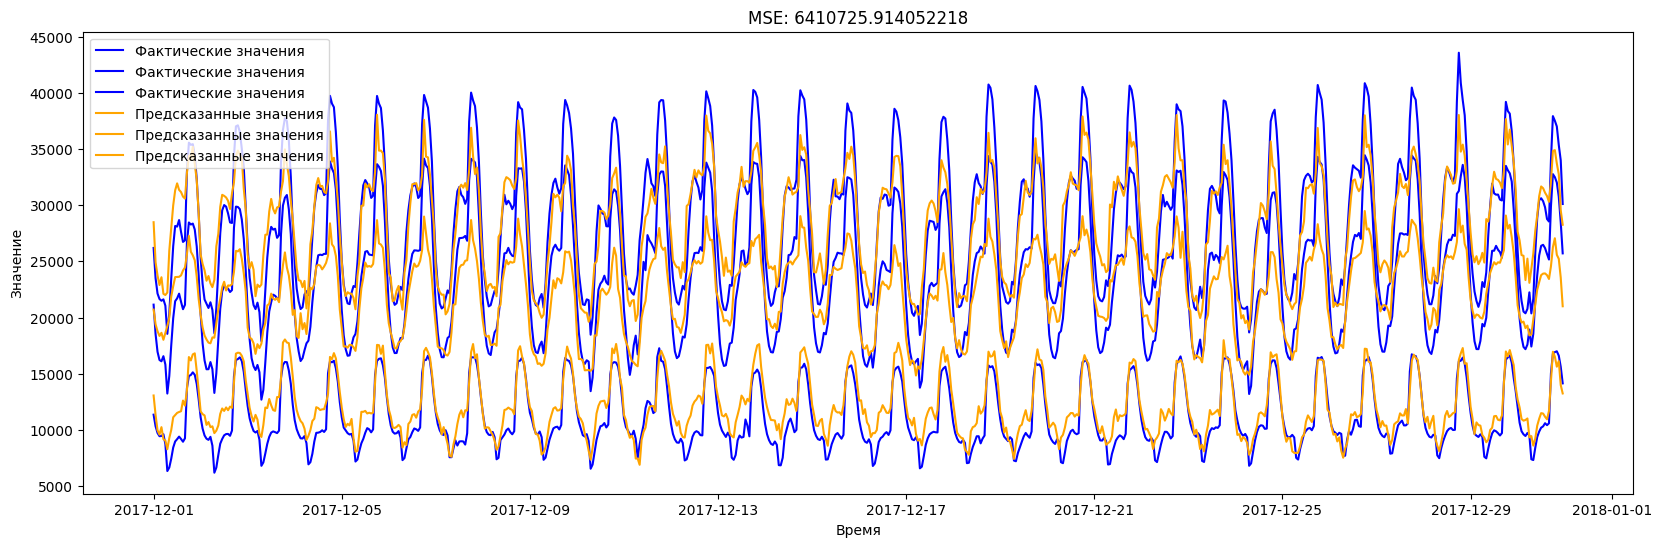

In [ ]:
# Построение графика фита
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', color='blue')
plt.plot(y_test.index, predictions, label='Предсказанные значения', color='orange')
plt.title(f'MSE: {mse_value}')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()

# Вывод графиков
plt.show()

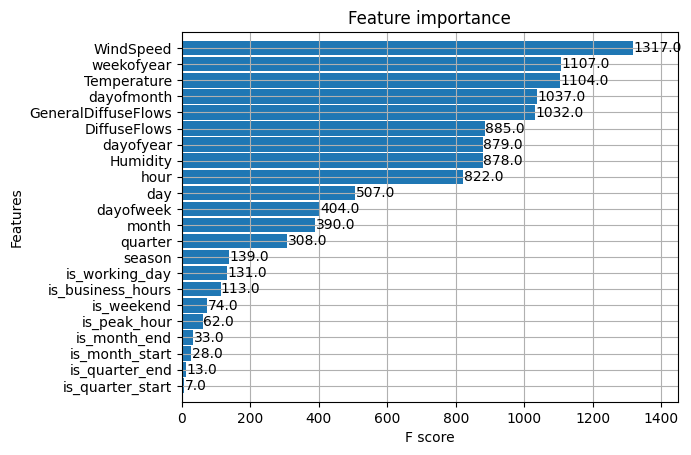

In [ ]:
_ = plot_importance(model, height=0.9)

Проведено сравнение с результатами из статьи 'A Novel Optimized Variant of Machine Learning
Algorithm for Accurate Energy Demand Prediction for
Tetouan City, Morocco'

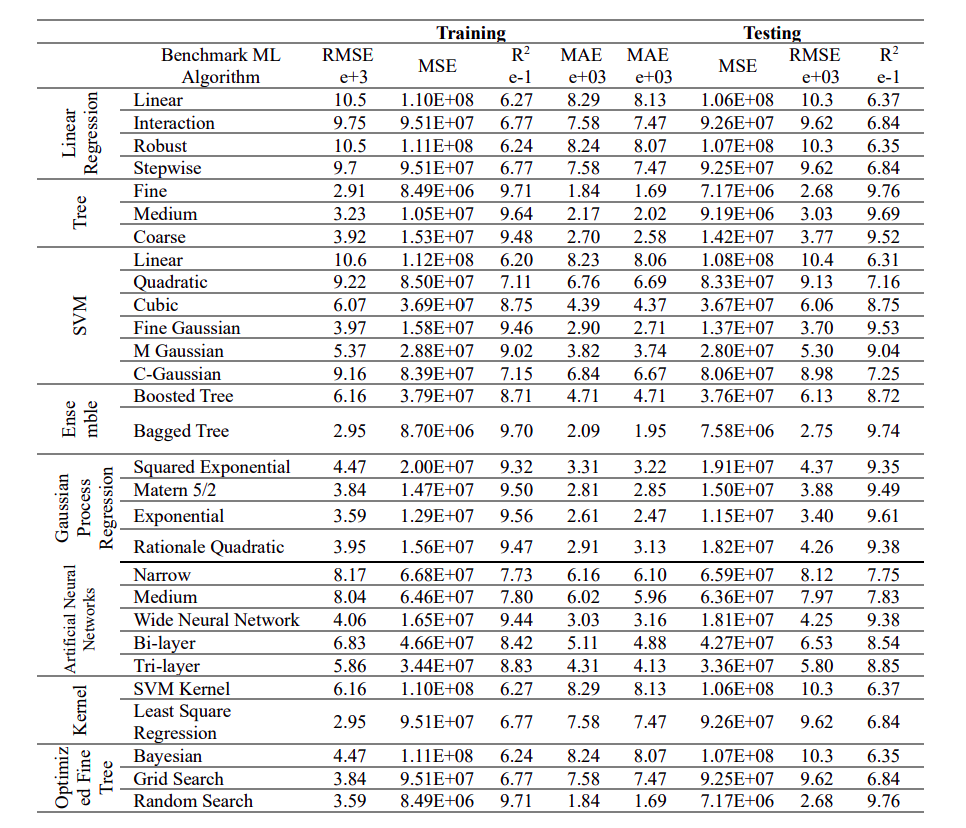

In [17]:
from google.colab import files
from io import BytesIO
from PIL import Image

im = Image.open('/content/drive/MyDrive/mse.png')
display(im)